In [1]:
# This is the parameters cell
projection_paths = './Output/quickdraw-tsne_s1_30p.csv'

# projection_paths = ''

In [2]:
projection_paths = projection_paths.split(' ')
dataset_id = projection_paths[0].split('/')[-1].split('-')[0]
print(projection_paths, dataset_id)

['./Output/quickdraw-tsne_s1_30p.csv'] quickdraw


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
import cv2
import re
import glob
import sys
from sklearn.neighbors import NearestNeighbors
from natsort import natsorted
from tqdm import tqdm
import os
# Uncomment next line if testing
os.chdir('..')

sys.stderr = open('Metrics/log_' + dataset_id, 'w') # to check tqdm progress followed by watch -n 1 cat logfile


IMAGE_DATASETS = ['quickdraw', 'fashion']
# K_VALUES = [.05, .1, .15, .2] 
K_VALUES = [i/100 for i in range(1,21)]

# Stability metrics

In [4]:
def get_projection_as_array(dataset_path):
    df = pd.read_csv(dataset_path, index_col=0)
    vs = df.values.reshape(len(df), -1, 2)
    return vs, list(df.index), vs.shape[1]


def get_md_mov(dataset_path):
    vs, indexes, n_timesteps = get_projection_as_array(dataset_path)
    mov = []
    for poly in vs:
        mov_i = []
        for i in range(len(poly)-1):
            mov_i.append(math.sqrt(np.sum(np.square(poly[i] - poly[i+1]))))
        mov.append(np.array(mov_i))
    return np.array(mov), indexes, n_timesteps


# get_md_mov('./Output/quickdraw-pca_s4.csv')

In [5]:
def image_dataset_to_array(dataset_path):
    # Convert image to np array
    # Preload images to memory (trying to speed things up)
    all_files = glob.glob('{}*'.format(dataset_path))
    # Gather ids and timestep info    
    max_t = {}
    for f in all_files:
        regex = r".*/{}/(.*-.*)-(.*).png".format(dataset_id)
        match = re.match(regex, f)
        img_id, t = match.groups()
        t = int(t)
        max_t[img_id] = max_t[img_id] if img_id in max_t and max_t[img_id] > t else t   
    
    img_size = 28 * 28  # Pixel count
    n_revisions = max(max_t.values()) + 1
    n_items = len(max_t.values())
    vs = np.empty((n_revisions, n_items, img_size))
    
    # Populate vs
    for i, img_id in enumerate(natsorted(max_t)):
        # Copy existing bitmaps to np.array
        for t in range(0, max_t[img_id]):
            img_file = dataset_path + img_id + '-' + str(t) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()
        # Replicate last image
        for t in range(max_t[img_id], n_revisions):
            img_file = dataset_path + img_id + '-' + str(max_t[img_id]-1) + '.png'
            vs[t][i] = (cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) / 255.).flatten()    
    return vs, list(natsorted(max_t)), n_revisions


def tabular_dataset_to_array(dataset_path):
    # Get files with coords and save in an array vs
    all_files = natsorted(glob.glob('{}*'.format(dataset_path)))
    vs = [pd.read_csv(f, index_col=0).values for f in all_files] 
    # Get dataset info 
    df_temp = pd.read_csv(all_files[0], index_col=0)
    n_timesteps = len(all_files)
    return np.array(vs), list(df_temp.index), n_timesteps


def dataset_as_array(dataset_path):
    if dataset_id in IMAGE_DATASETS:
         return image_dataset_to_array(dataset_path)
    else:
        return tabular_dataset_to_array(dataset_path)


def get_nd_mov(dataset_id):
    mov = []
    dataset_path = './Datasets/' + dataset_id + '/'
    # Get the nd data into arrays
    vs, indexes, n_timesteps = dataset_as_array(dataset_path)
    # Compute dists between 2 nd arrays
    for t in range(n_timesteps - 1):
        v_t = vs[t]
        v_tp1 = vs[t+1]
        mov_t = []
        for a, b in zip(v_t, v_tp1):
            mov_t.append(math.sqrt(np.sum(np.square(a - b))))
        mov.append(np.array(mov_t)) 
    return np.array(mov).T, indexes, n_timesteps

# dists, indexes, n_timesteps = get_nd_dists('quickdraw')

In [6]:
# Compute distances
mov_nd, indexes, n_timesteps = get_nd_mov(dataset_id)
mov_md_dict = {}
for p in projection_paths:
    mov, _, _ = get_md_mov(p)
    mov_md_dict[p] = mov

In [7]:
metric_ids = ['stab_pearson', 'stab_spearman', 'stab_kendall', 'stab_kl', 'stab_stress_n', 'stab_stress_s',
              'spat_pearson', 'spat_spearman', 'spat_kendall', 'spat_kl', 'spat_stress_n', 'spat_stress_s']

for i in range(len(K_VALUES)):
    metric_ids.append('spat_np_' + str(i+1))
for i in range(len(K_VALUES)):
    metric_ids.append('spat_nh_' + str(i+1))

metric_results = pd.DataFrame(np.zeros((len(projection_paths), len(metric_ids))),
                              index=projection_paths, columns=metric_ids)
# metric_results

# Stability metrics

In [8]:
# Flatten the data
mov_nd = mov_nd.flatten()
for p in projection_paths:
    mov_md = mov_md_dict[p].flatten()

    # Correlation and divergence metrics
    metric_results.loc[p]['stab_pearson']  = scipy.stats.pearsonr(mov_nd, mov_md)[0]
    metric_results.loc[p]['stab_spearman'] = scipy.stats.spearmanr(mov_nd, mov_md)[0]
    metric_results.loc[p]['stab_kendall']  = scipy.stats.kendalltau(mov_nd, mov_md)[0]
    metric_results.loc[p]['stab_kl']       = scipy.stats.entropy(mov_nd, mov_md)

    # Stress metrics
    nd = mov_nd / max(mov_nd)
    md = mov_md / max(mov_md)
    metric_results.loc[p]['stab_stress_n'] = np.sum(np.square(nd - md)) / np.sum(np.square(nd))

    nd = (mov_nd - np.mean(mov_nd)) / np.std(mov_nd)
    md = (mov_md - np.mean(mov_md)) / np.std(mov_md)
    metric_results.loc[p]['stab_stress_s'] = np.sum(np.square(nd - md)) / np.sum(np.square(nd))

# display(metric_results)

# Spatial metrics

In [9]:
def trustworthiness_metric(nbrs_nd, nbrs_md, k):
    sum_i = 0
    for i in range(n_items):
        # Look for false neighbors in a k sized neighborhood
        knbrs_nd = nbrs_nd[i, 1:k+1]
        knbrs_md = nbrs_md[i, 1:k+1]
        U = np.setdiff1d(knbrs_nd, knbrs_md, assume_unique=True)

        # For each false neighbor in mD, find out its rank in nD and sum it
        sum_j = 0
        for j in U: 
            sum_j += int(np.where(nbrs_md[i] == j)[0] - 1) - k   
        sum_i += int(sum_j)

    n = n_items
    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)))

def continuity_metric(nbrs_nd, nbrs_md, k):
    sum_i = 0
    for i in range(n_items):
        # Look for false neighbors in a k sized neighborhood
        knbrs_nd = nbrs_nd[i, 1:k+1]
        knbrs_md = nbrs_md[i, 1:k+1]
        U = np.setdiff1d(knbrs_md, knbrs_nd, assume_unique=True)

        # For each false neighbor in nD, find out its rank in mD and sum it
        sum_j = 0
        for j in U: 
            sum_j += int(np.where(nbrs_nd[i] == j)[0] - 1) - k   
        sum_i += int(sum_j)

    n = n_items
    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)))

In [10]:
%%time

dataset_path = './Datasets/' + dataset_id + '/'
vs_n, indexes, n_revisions = dataset_as_array(dataset_path)
n_items = len(indexes)

for p in projection_paths:
    # Change axis in projection
    vs_m, _, _ = get_projection_as_array(p)
    vs_m = np.transpose(vs_m, (1,0,2))
    
    # Initialize structures
    index_to_class = np.array([item.split('-')[0] for item in np.array(indexes)])
    dists_nd_all = []
    dists_md_all = [] 
    ngbr_preservation = np.zeros((n_timesteps, n_items, len(K_VALUES)))
    ngbr_hit = np.zeros((n_timesteps, n_items, len(K_VALUES)))
    trustworthiness = np.zeros((n_timesteps, len(K_VALUES)))
    continuity = np.zeros((n_timesteps, len(K_VALUES)))
    
    for t in tqdm(range(n_timesteps)):
        # Generate list of nearest neighbors for each item in timestep t
        dists_nd, nbrs_nd = NearestNeighbors(n_neighbors=n_items, metric='euclidean',
                                      algorithm='ball_tree').fit(vs_n[t]).kneighbors(vs_n[t])   
        dists_md, nbrs_md = NearestNeighbors(n_neighbors=n_items, metric='euclidean',
                                      algorithm='kd_tree').fit(vs_m[t]).kneighbors(vs_m[t])
        
        # Save distances to compute correlation/stress metrics
        dists_nd_all.append(dists_nd)
        dists_md_all.append(dists_md)
        
        # Check classes of neighbors for neighbor hit metric
        for i in range(n_items):
            i_class = index_to_class[i]
            k_max = int(max(K_VALUES) * n_items)
            ngbr_classes = index_to_class[nbrs_md[i, :k_max]]
            for k_index, k_percentage in enumerate(K_VALUES):
                k = max(int(k_percentage * n_items), 1)  # Avoid divisions by 0
                ngbr_classes = ngbr_classes[:k]
                nh = sum(map(lambda x: x == i_class, ngbr_classes)) / float(k)
                ngbr_hit[t][i][k_index] = nh  

        # Compute neighbor preservation for different values of k for each item 
        for i in range(n_items):
            for k_index, k_percentage in enumerate(K_VALUES):
                k = max(int(k_percentage * n_items), 1)  # Avoid divisions by 0
                intersection = np.intersect1d(nbrs_nd[i, :k], nbrs_md[i, :k], assume_unique=True)
                ngbr_preservation[t][i][k_index] = len(intersection) / float(k)
                
        # Compute trustworthiness
        for k_index, k_percentage in enumerate(K_VALUES):
            k = max(int(k_percentage * n_items), 1)  # Avoid divisions by 0
            trustworthiness[t][k_index] = trustworthiness_metric(nbrs_nd, nbrs_md, k)
            continuity[t][k_index] = continuity_metric(nbrs_nd, nbrs_md, k)
        
        
    # Average values over TIME (axis 0)
    ngbr_preservation = np.average(ngbr_preservation, axis=0)
    ngbr_hit = np.average(ngbr_hit, axis=0)
    trustworthiness = np.average(trustworthiness, axis=0)
    continuity = np.average(continuity, axis=0)

    # Then average values over all points (new axis 0)
    ngbr_preservation = np.average(ngbr_preservation, axis=0)
    ngbr_hit = np.average(ngbr_hit, axis=0)

    # We get one value per k
    for i in range(len(K_VALUES)):
        metric_results.loc[p]['spat_np_' + str(i+1)] = ngbr_preservation[i]
        metric_results.loc[p]['spat_nh_' + str(i+1)] = ngbr_hit[i]
    
    dists_nd_all = np.array(dists_nd_all)
    dists_md_all = np.array(dists_md_all)
    dists_nd_all = dists_nd_all.flatten()
    dists_md_all = dists_md_all.flatten()

    # Stress metrics
    nd = dists_nd_all / max(dists_nd_all)
    md = dists_md_all / max(dists_md_all)
    metric_results.loc[p]['spat_stress_n'] = np.sum(np.square(nd - md)) / np.sum(np.square(nd))

    nd = (dists_nd_all - np.mean(dists_nd_all)) / np.std(dists_nd_all)
    md = (dists_md_all - np.mean(dists_md_all)) / np.std(dists_md_all)
    metric_results.loc[p]['spat_stress_s'] = np.sum(np.square(nd - md)) / np.sum(np.square(nd))
    
    # Correlation and divergence metrics
    metric_results.loc[p]['spat_pearson']  = scipy.stats.pearsonr(dists_nd_all, dists_md_all)[0]
    metric_results.loc[p]['spat_spearman'] = scipy.stats.spearmanr(dists_nd_all, dists_md_all)[0]
    metric_results.loc[p]['spat_kendall']  = scipy.stats.kendalltau(dists_nd_all, dists_md_all)[0]
    metric_results.loc[p]['spat_kl']       = scipy.stats.entropy(dists_nd_all, dists_md_all)

CPU times: user 9min 57s, sys: 8.38 s, total: 10min 6s
Wall time: 10min 8s


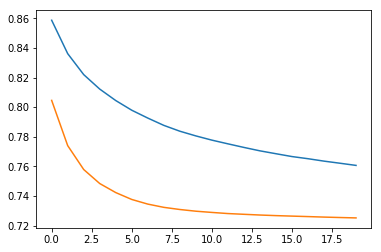

In [11]:
plt.plot(trustworthiness)
plt.plot(continuity)

In [12]:
projection_paths

['./Output/quickdraw-tsne_s1_30p.csv']

In [13]:
display(metric_results)

,stab_pearson,stab_spearman,stab_kendall,stab_kl,stab_stress_n,stab_stress_s,spat_pearson,spat_spearman,spat_kendall,spat_kl,...,spat_nh_11,spat_nh_12,spat_nh_13,spat_nh_14,spat_nh_15,spat_nh_16,spat_nh_17,spat_nh_18,spat_nh_19,spat_nh_20
./Output/quickdraw-tsne_s1_30p.csv,0.117686,0.071949,0.054568,1.41692,0.849629,1.764627,0.092028,0.243789,0.178169,0.4155,...,0.061265,0.05616,0.05184,0.048137,0.044928,0.04212,0.039642,0.03744,0.035469,0.033696


In [14]:
# metric_results.to_csv('./Metrics/Results/{}.csv'.format(dataset_id))

20

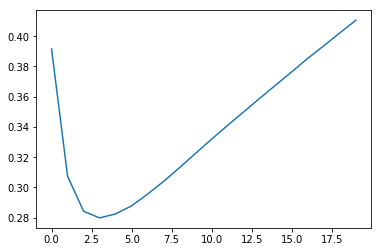

In [15]:
plt.plot(metric_results[[c for c in metric_results.columns if c.startswith('spat_np_')]].values.flatten())
len(metric_results[[c for c in metric_results.columns if c.startswith('spat_np_')]].values.flatten())

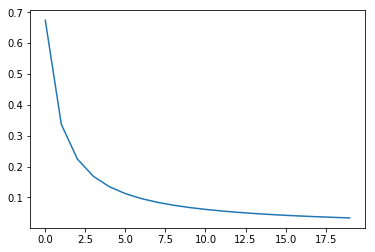

In [16]:
plt.plot(metric_results[[c for c in metric_results.columns if c.startswith('spat_nh_')]].values.flatten())
